In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_PATH = "drive/MyDrive/Courses/DeepLearning/Project/"
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]
data = pd.read_csv(f'{BASE_PATH}NSL-KDD/KDDTrain+.txt',header=None, names=col_names)

# remove attribute 'difficulty_level'
data.drop(['difficulty_level'],axis=1,inplace=True)

def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

change_label(data)

numeric_col = data.select_dtypes(include='number').columns

# using standard scaler for normalizing
std_scaler = StandardScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

# calling the normalization() function
data = normalization(data.copy(),numeric_col)

# selecting categorical data attributes
cat_col = ['protocol_type','service','flag']

# creating a dataframe with only categorical attributes
categorical = data[cat_col]

# one-hot-encoding categorical attributes using pandas.get_dummies() function
categorical = pd.get_dummies(categorical,columns=cat_col)

# changing attack labels into two categories 'normal' and 'abnormal'
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))

# creating a dataframe with binary labels (normal,abnormal)
bin_data = data.copy()
bin_data['label'] = bin_label

# label encoding (0,1) binary labels (abnormal,normal)
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['intrusion'] = enc_label

np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

# one-hot-encoding attack label
bin_data = pd.get_dummies(bin_data,columns=['label'],prefix="",prefix_sep="")
bin_data['label'] = bin_label

# creating a dataframe with only numeric attributes of binary class dataset and encoded label attribute
numeric_bin = bin_data[numeric_col]
numeric_bin['intrusion'] = bin_data['intrusion']

# finding the attributes which have more than 0.5 correlation with encoded attack label attribute
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_data[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
                         'logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]

# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = numeric_bin.join(categorical)
# then joining encoded, one-hot-encoded, and original attack label attribute
bin_data = numeric_bin.join(bin_data[['intrusion','abnormal','normal','label']])

# saving final dataset to disk
bin_data.to_csv(f"{BASE_PATH}bin_data.csv")


<ipython-input-3-840bd6247746>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_bin['intrusion'] = bin_data['intrusion']


# GANS

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.functional import sigmoid, softmax
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary

instance_shape = 93
latent_dim = 10
# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
# Build the encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )
        # self.model.apply(initializer)

    def forward(self, x):
        return self.model(x)

# Build the generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Build the discriminator model
class Discriminator(nn.Module):
    def __init__(self, latent_dim, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(latent_dim + input_dim, 64)
        self.mid1 = nn.Linear(64, 32)
        self.mid2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, output_dim)

    def forward(self, z, img):
        d_in = torch.cat((z, img), dim=1)
        model = nn.LeakyReLU(0.2)(self.fc(d_in))
        model = nn.LeakyReLU(0.2)(self.mid1(model))
        model = nn.LeakyReLU(0.2)(self.mid2(model))
        validity = torch.sigmoid(self.out(model))
        return validity


Normal Training

In [165]:
encoder_normal = Encoder(instance_shape, latent_dim)
encoder_normal = encoder_normal.to(device)
print(encoder_normal)

generator_normal = Generator(latent_dim, instance_shape)
generator_normal = generator_normal.to(device)
print(generator_normal)

discriminator = Discriminator(latent_dim, instance_shape, 1)
discriminator = discriminator.to(device)
print(discriminator)
print(sum(p.numel() for p in discriminator.parameters()))

Encoder(
  (model): Sequential(
    (0): Linear(in_features=93, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=93, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (fc): Linear(in_features=103, out_features=64, bias=True)
  (mid1): Linear(in_features=64, out_features=32, bias=True)
  (mid2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
9281


In [166]:
# Define loss functions and optimizers
adv_loss = nn.BCELoss()  # Binary cross-entropy loss for adversarial training

optimizer_enc = optim.Adam(encoder_normal.parameters(), lr=0.002)
optimizer_gen = optim.Adam(generator_normal.parameters(), lr=0.002)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.002)

# Training loop
num_epochs = 1000  # Adjust as needed
batch_size = 128  # Adjust as needed

valid = torch.zeros(batch_size, 1).to(device)
fake = torch.ones(batch_size, 1).to(device)
sample_interval = 10

In [167]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

bin_data_normal = bin_data[bin_data.normal==1]
X = bin_data_normal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data_normal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# n_noise = 64


train_losses = []
train_accs = []
val_losses = []
val_accs = []
gen_loss = []
disc_loss = []
enc_loss = []
disc_acc = []
for epoch in range(num_epochs):
  # Set the models to train mode
    encoder_normal.train()
    generator_normal.train()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    train_iter = iter(train_loader)
    real_data, labels = next(train_iter)
    optimizer_disc.zero_grad()
    discriminator.train()
    real_data, labels = real_data.to(device), labels.to(device)

    # Discriminator

    # Fake
    noise = torch.randn(batch_size, latent_dim).to(device)
    fake_data = generator_normal(noise)
    disc_outputs_fake = discriminator(fake_data, noise)
    loss_disc_fake = adv_loss(disc_outputs_fake, torch.zeros_like(disc_outputs_fake))
    loss_disc_fake.backward()
    disc_acc_fake = (disc_outputs_fake < 0.5).float().mean().item() * 100
    # Real
    real_latent = encoder_normal(real_data)
    disc_outputs_real = discriminator(real_data, real_latent)
    loss_disc_real = adv_loss(disc_outputs_real, torch.ones_like(disc_outputs_real))
    loss_disc_real.backward()
    disc_acc_real = (disc_outputs_real >= 0.5).float().mean().item() * 100


    # Average the two losses
    loss_disc = 0.5*(loss_disc_real + loss_disc_fake)
    acc_disc = 0.5 * (disc_acc_fake + disc_acc_real)
    # loss_disc.backward()
    optimizer_disc.step()
    discriminator.trainable = False
    optimizer_enc.zero_grad()
    optimizer_gen.zero_grad()
    k = 5
    for _ in range(k):
      optimizer_enc.step()
      optimizer_gen.step()

      # Train Generator
      real_latent = encoder_normal(real_data)
      noise = torch.randn(batch_size, latent_dim).to(device)
      fake_data = generator_normal(noise)

      disc_outputs_fake = discriminator(fake_data, noise)
      loss_gen = adv_loss(disc_outputs_fake, torch.ones_like(disc_outputs_fake))

      disc_outputs_real = discriminator(real_data, real_latent)
      loss_enc = adv_loss(disc_outputs_real, torch.zeros_like(disc_outputs_real))

      # loss_gen = -loss_gen
      # loss_enc = -loss_enc
      # loss_enc_gen = loss_gen + loss_enc
      loss_gen.backward()
      loss_enc.backward()
      # loss_enc_gen.backward()
      optimizer_enc.step()
      optimizer_gen.step()
    gen_loss.append(loss_gen.cpu())
    disc_loss.append(loss_disc.cpu())
    enc_loss.append(loss_enc.cpu())
    disc_acc.append(acc_disc)
    print(f"Epoch {epoch}/{num_epochs} Discriminator Loss {loss_disc} Discriminator Accuracy {acc_disc}, Generator Loss {loss_gen}, Encoder Loss {loss_enc}")

Epoch 0/1000 Discriminator Loss 0.6985338926315308 Discriminator Accuracy 50.0, Generator Loss 0.7862875461578369, Encoder Loss 0.6177173256874084
Epoch 1/1000 Discriminator Loss 0.6913405656814575 Discriminator Accuracy 50.0, Generator Loss 0.7923663258552551, Encoder Loss 0.6233581304550171
Epoch 2/1000 Discriminator Loss 0.6858036518096924 Discriminator Accuracy 50.0, Generator Loss 0.7933729887008667, Encoder Loss 0.629889726638794
Epoch 3/1000 Discriminator Loss 0.682335615158081 Discriminator Accuracy 50.0, Generator Loss 0.7904196381568909, Encoder Loss 0.6388171315193176
Epoch 4/1000 Discriminator Loss 0.6784559488296509 Discriminator Accuracy 50.0, Generator Loss 0.7913882732391357, Encoder Loss 0.6466994285583496
Epoch 5/1000 Discriminator Loss 0.6732556819915771 Discriminator Accuracy 50.0, Generator Loss 0.794577956199646, Encoder Loss 0.6557956337928772
Epoch 6/1000 Discriminator Loss 0.6674617528915405 Discriminator Accuracy 50.0, Generator Loss 0.7922155261039734, Encode

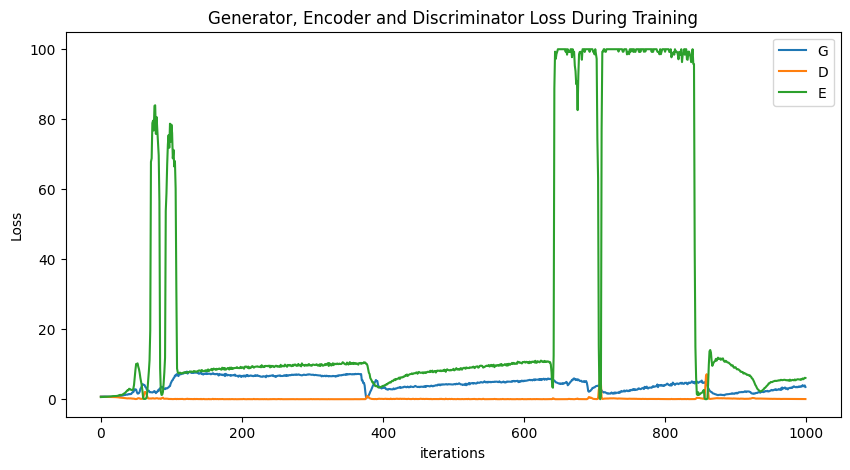

In [168]:
%matplotlib inline
D_losses = [i.detach().numpy() for i in disc_loss]
G_losses = [i.detach().numpy() for i in gen_loss]
E_losses = [i.detach().numpy() for i in enc_loss]
plt.figure(figsize=(10,5))
plt.title("Generator, Encoder and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(E_losses,label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

# Testing

In [169]:
# Test Normal
bin_data_normal = bin_data[bin_data.normal==1]
X_nor = bin_data_normal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y_nor = bin_data_normal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_nor_tensor = torch.tensor(X_nor, dtype=torch.float32)
Y_nor_tensor = torch.tensor(Y_nor, dtype=torch.float32)

test_nor_dataset = TensorDataset(X_nor_tensor, Y_nor_tensor)
test_nor_loader = DataLoader(test_nor_dataset, batch_size=batch_size, shuffle=True)

test_nor_iter = iter(test_nor_loader)
nor_data, labels = next(test_nor_iter)
nor_data, labels = nor_data.to(device), labels.to(device)
nor_latent = encoder_normal(nor_data)
disc_outputs_nor = discriminator(nor_data, nor_latent)
disc_acc_nor = (disc_outputs_nor >= 0.5).float().mean().item() * 100
disc_acc_nor

96.875

In [ ]:
# disc_outputs_nor

In [170]:
# Test Abnormal
bin_data_abnormal = bin_data[bin_data.normal==0]
X_ab = bin_data_abnormal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y_ab = bin_data_abnormal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_ab_tensor = torch.tensor(X_ab, dtype=torch.float32)
Y_ab_tensor = torch.tensor(Y_ab, dtype=torch.float32)

test_ab_dataset = TensorDataset(X_ab_tensor, Y_ab_tensor)
test_ab_loader = DataLoader(test_ab_dataset, batch_size=batch_size, shuffle=True)

test_iter = iter(test_ab_loader)
ab_data, labels = next(test_iter)
ab_data, labels = ab_data.to(device), labels.to(device)
ab_latent = encoder_abnormal(ab_data)
disc_outputs_ab = discriminator(ab_data, ab_latent)
disc_acc_ab = (disc_outputs_ab < 0.5).float().mean().item() * 100
disc_acc_ab

65.625

#Ab-Normal Training

In [171]:
encoder_abnormal = Encoder(instance_shape, latent_dim)
encoder_abnormal = encoder_abnormal.to(device)
print(encoder_abnormal)

generator_abnormal = Generator(latent_dim, instance_shape)
generator_abnormal = generator_abnormal.to(device)
print(generator_abnormal)

discriminator.fc.requires_grad = False
discriminator.mid1.requires_grad = False

Encoder(
  (model): Sequential(
    (0): Linear(in_features=93, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=93, bias=True)
    (5): Sigmoid()
  )
)


In [172]:
# Define loss functions and optimizers
adv_loss = nn.BCELoss()  # Binary cross-entropy loss for adversarial training

optimizer_enc = optim.Adam(encoder_abnormal.parameters(), lr=0.002)
optimizer_gen = optim.Adam(generator_abnormal.parameters(), lr=0.002)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop
num_epochs = 1000  # Adjust as needed
batch_size = 128  # Adjust as needed

valid = torch.zeros(batch_size, 1).to(device)
fake = torch.ones(batch_size, 1).to(device)
sample_interval = 10

In [173]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

bin_data_abnormal = bin_data[bin_data.normal==0]
X = bin_data_abnormal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data_abnormal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# n_noise = 64


train_losses = []
train_accs = []
val_losses = []
val_accs = []
gen_loss = []
disc_loss = []
enc_loss = []
disc_acc = []
for epoch in range(num_epochs):
  # Set the models to train mode
    encoder_abnormal.train()
    generator_abnormal.train()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    train_iter = iter(train_loader)
    real_data, labels = next(train_iter)
    optimizer_disc.zero_grad()
    discriminator.train()
    real_data, labels = real_data.to(device), labels.to(device)

    # Discriminator

    # Fake
    noise = torch.randn(batch_size, latent_dim).to(device)
    fake_data = generator_abnormal(noise)
    disc_outputs_fake = discriminator(fake_data, noise)
    loss_disc_fake = adv_loss(disc_outputs_fake, torch.ones_like(disc_outputs_fake))
    loss_disc_fake.backward()
    disc_acc_fake = (disc_outputs_fake >= 0.5).float().mean().item() * 100
    # Real
    real_latent = encoder_abnormal(real_data)
    disc_outputs_real = discriminator(real_data, real_latent)
    loss_disc_real = adv_loss(disc_outputs_real, torch.zeros_like(disc_outputs_real))
    loss_disc_real.backward()
    disc_acc_real = (disc_outputs_real < 0.5).float().mean().item() * 100


    # Average the two losses
    loss_disc = 0.5*(loss_disc_real + loss_disc_fake)
    acc_disc = 0.5 * (disc_acc_fake + disc_acc_real)
    # loss_disc.backward()
    optimizer_disc.step()
    discriminator.trainable = False
    optimizer_enc.zero_grad()
    optimizer_gen.zero_grad()
    k = 5
    for _ in range(k):
      optimizer_enc.step()
      optimizer_gen.step()

      # Train Generator
      real_latent = encoder_abnormal(real_data)
      noise = torch.randn(batch_size, latent_dim).to(device)
      fake_data = generator_abnormal(noise)

      disc_outputs_fake = discriminator(fake_data, noise)
      loss_gen = adv_loss(disc_outputs_fake, torch.zeros_like(disc_outputs_fake))

      disc_outputs_real = discriminator(real_data, real_latent)
      loss_enc = adv_loss(disc_outputs_real, torch.ones_like(disc_outputs_real))

      # loss_gen = -loss_gen
      # loss_enc = -loss_enc
      # loss_enc_gen = loss_gen + loss_enc
      loss_gen.backward()
      loss_enc.backward()
      # loss_enc_gen.backward()
      optimizer_enc.step()
      optimizer_gen.step()
    gen_loss.append(loss_gen.cpu())
    disc_loss.append(loss_disc.cpu())
    enc_loss.append(loss_enc.cpu())
    disc_acc.append(acc_disc)
    print(f"Epoch {epoch}/{num_epochs} Discriminator Loss {loss_disc} Discriminator Accuracy {acc_disc}, Generator Loss {loss_gen}, Encoder Loss {loss_enc}")

Epoch 0/1000 Discriminator Loss 3.1325087547302246 Discriminator Accuracy 30.859375, Generator Loss 0.05294056609272957, Encoder Loss 2.803075075149536
Epoch 1/1000 Discriminator Loss 3.1548709869384766 Discriminator Accuracy 31.640625, Generator Loss 0.059529948979616165, Encoder Loss 1.6626760959625244
Epoch 2/1000 Discriminator Loss 2.989145278930664 Discriminator Accuracy 33.203125, Generator Loss 0.03901105374097824, Encoder Loss 1.0232172012329102
Epoch 3/1000 Discriminator Loss 3.772465467453003 Discriminator Accuracy 32.8125, Generator Loss 0.02082524076104164, Encoder Loss 0.9351481199264526
Epoch 4/1000 Discriminator Loss 4.585761547088623 Discriminator Accuracy 27.34375, Generator Loss 0.019903559237718582, Encoder Loss 0.7604433298110962
Epoch 5/1000 Discriminator Loss 4.430278778076172 Discriminator Accuracy 28.515625, Generator Loss 0.023841898888349533, Encoder Loss 0.7532626986503601
Epoch 6/1000 Discriminator Loss 4.063364505767822 Discriminator Accuracy 28.515625, Gen

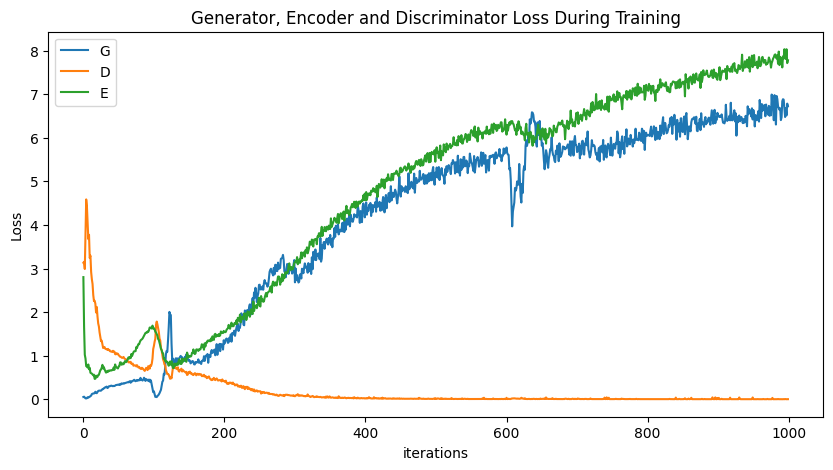

In [174]:
%matplotlib inline
D_losses = [i.detach().numpy() for i in disc_loss]
G_losses = [i.detach().numpy() for i in gen_loss]
E_losses = [i.detach().numpy() for i in enc_loss]
plt.figure(figsize=(10,5))
plt.title("Generator, Encoder and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(E_losses,label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

# Testing

In [179]:
# Test Normal
bin_data_normal = bin_data[bin_data.normal==1]
X_nor = bin_data_normal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y_nor = bin_data_normal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_nor_tensor = torch.tensor(X_nor, dtype=torch.float32)
Y_nor_tensor = torch.tensor(Y_nor, dtype=torch.float32)

test_nor_dataset = TensorDataset(X_nor_tensor, Y_nor_tensor)
test_nor_loader = DataLoader(test_nor_dataset, batch_size=batch_size, shuffle=True)

test_nor_iter = iter(test_nor_loader)
nor_data, labels = next(test_nor_iter)
nor_data, labels = nor_data.to(device), labels.to(device)
nor_latent = encoder_normal(nor_data)
disc_outputs_nor = discriminator(nor_data, nor_latent)
disc_acc_nor = (disc_outputs_nor >= 0.5).float().mean().item() * 100
disc_acc_nor

1.5625

In [97]:
# disc_outputs_nor

In [176]:
# Test Abnormal
bin_data_abnormal = bin_data[bin_data.normal==0]
X_ab = bin_data_abnormal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y_ab = bin_data_abnormal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_ab_tensor = torch.tensor(X_ab, dtype=torch.float32)
Y_ab_tensor = torch.tensor(Y_ab, dtype=torch.float32)

test_ab_dataset = TensorDataset(X_ab_tensor, Y_ab_tensor)
test_ab_loader = DataLoader(test_ab_dataset, batch_size=batch_size, shuffle=True)

test_iter = iter(test_ab_loader)
ab_data, labels = next(test_iter)
ab_data, labels = ab_data.to(device), labels.to(device)
ab_latent = encoder_abnormal(ab_data)
disc_outputs_ab = discriminator(ab_data, ab_latent)
disc_acc_ab = (disc_outputs_ab < 0.5).float().mean().item() * 100
disc_acc_ab

100.0